In [1]:
import json
import numpy as np
import pandas as pd
import os
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import PIL
from PIL import ImageDraw
import multiprocessing as mp

%pylab inline
import matplotlib.pylab as plt
import seaborn as sns
plt.style.use('ggplot')
plt.style.use('seaborn-poster')
sns.set(style='white', context='notebook', palette='deep')

%env KERAS_BACKEND tensorflow

Populating the interactive namespace from numpy and matplotlib
env: KERAS_BACKEND=tensorflow


In [18]:
from helpers import im2arr

px = 96
border_px = 2

In [19]:
result_path = '../model/'
df = pd.read_csv('data/df.csv')
train = np.load('data/strokes_raw.npy')
print(df.shape[0])

350000


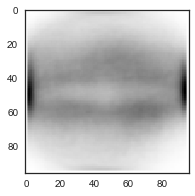

In [20]:
# We'll need to substract mean global from each pixel, but we can't calculate it,
# so we will be updating mean global during training. For now initialize it with 100 random batches.

batch_counter = 0
mean_global = np.zeros((px, px))

for i in range(10):
    batch = np.random.choice(train, 1000)
    batch = np.array([im2arr(drawing) for drawing in batch])
    
    mean_global = (mean_global * batch_counter + batch.mean(axis=0)) / (batch_counter+1)
    batch_counter += 1
    
plt.figure(figsize(3,3))
plt.imshow(-mean_global, cmap='gray');
mean_global = mean_global.mean()

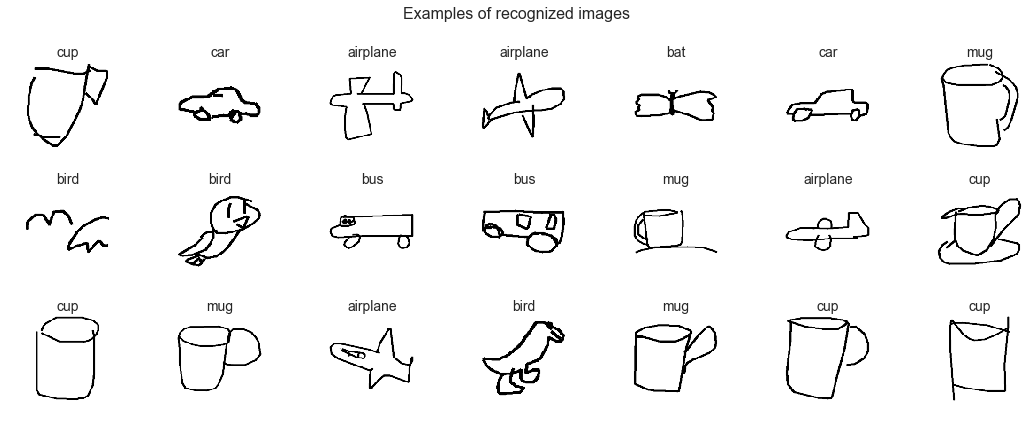

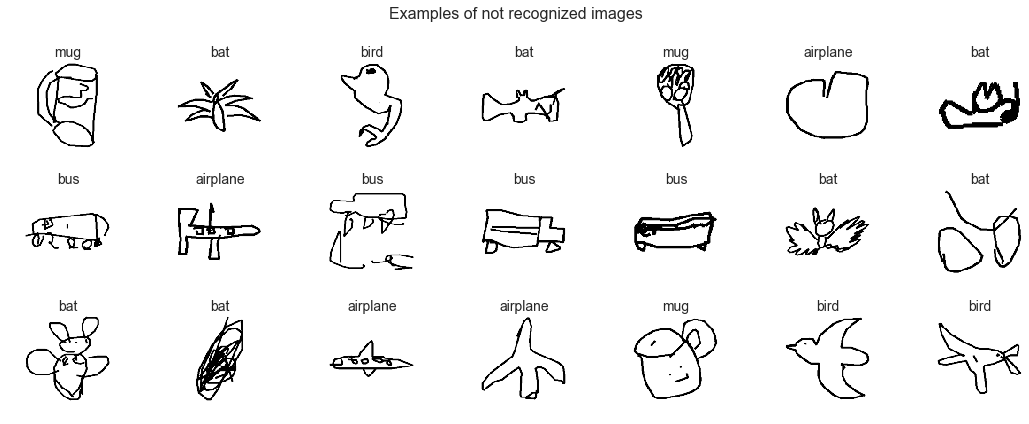

In [21]:
def plot_on_grid(title, recognized):
    fig = plt.figure(figsize=(15,6))
    nrows, ncols = 3, 7
    fig.suptitle(title, fontsize=16)
    img_ids = np.random.choice(df[df.recognized==recognized].index, nrows*ncols)

    for i in range(nrows * ncols):
        image_ind = img_ids[i]
        ax = fig.add_subplot(nrows, ncols, i+1)        
        ax.axis('off')
        ax.imshow(im2arr(train[image_ind]))
        ax.set_title(df.target.loc[image_ind], fontsize=14)
        
    fig.tight_layout()
    fig.subplots_adjust(top=0.85)
    plt.show()
    
plot_on_grid("Examples of recognized images", 1)
plot_on_grid("Examples of not recognized images", 0)

In [22]:
valid_ids = df[df.recognized==1].index
train = train[valid_ids]
df = df.loc[valid_ids].reset_index(drop=True)
del (valid_ids)

le = LabelEncoder()
ytrain = le.fit_transform(df.target.values)


(train, valid,
 ytrain, yvalid,
 df, dfvalid) = train_test_split(train, ytrain, df, test_size=0.1, random_state=0)
num_classes = int(ytrain.max() + 1)

In [ ]:
np.save(result_path+'processing_params.npy', np.array([px, border_px]))
np.save(result_path+'classes.npy', le.classes_)

In [23]:
import torch.nn as nn
import torch.optim as optim
import torch
from torchsummary import summary

cpu_dtype = torch.FloatTensor # the CPU datatype
gpu_dtype = torch.cuda.FloatTensor

In [10]:
%load_ext autoreload
%autoreload 2
from torch_models import ConvNetSimple, InceptionBasedNet

In [ ]:
model = ConvNetSimple(num_classes, (1, px, px))#.type(cpu_dtype)
loss_fn = nn.CrossEntropyLoss()#.type(cpu_dtype)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# model = model.float()

print(summary(model, (1, px, px)))

In [30]:
model = InceptionBasedNet(num_classes, (1, px, px))
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
print(summary(model, (1, px, px)))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 92, 92]           3,328
         MaxPool2d-2          [-1, 128, 46, 46]               0
              ReLU-3          [-1, 128, 46, 46]               0
       BatchNorm2d-4          [-1, 128, 46, 46]             256
           Dropout-5          [-1, 128, 46, 46]               0
        conv_layer-6          [-1, 128, 46, 46]               0
            Conv2d-7           [-1, 32, 46, 46]           4,096
              ReLU-8           [-1, 32, 46, 46]               0
       BatchNorm2d-9           [-1, 32, 46, 46]              64
      BasicConv2d-10           [-1, 32, 46, 46]               0
           Conv2d-11           [-1, 32, 46, 46]           4,096
             ReLU-12           [-1, 32, 46, 46]               0
      BatchNorm2d-13           [-1, 32, 46, 46]              64
      BasicConv2d-14           [-1, 32,

In [37]:
from torch_trainer import Trainer

cpu_count = 4
epochs_num = 50
epoch_partion = 0.001
batch_size = 16

trainer = Trainer(model, loss_fn, optimizer, cpu_count, mean_global, px)
trainer.fit(train, ytrain, valid, yvalid, batch_size, epoch_partion, epochs_num, 4)

Started epoch 1


Process ForkPoolWorker-138:
Process ForkPoolWorker-140:
Process ForkPoolWorker-137:
Process ForkPoolWorker-139:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/Denis/anaconda/envs/python3/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/Denis/anaconda/envs/python3/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/Denis/anaconda/envs/python3/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/Users/Denis/anaconda/envs/python3/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/Denis/anaconda/envs/python3/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/Denis/anaconda/envs/python3/lib/python3.5/multiprocessing/proc

KeyboardInterrupt: 

False

In [ ]:
model = ConvNetSimple(322, (1, px, px)).float()
model.load_state_dict(torch.load('../model/TorchConvNet.t7', map_location='cpu'))
model.eval()

In [ ]:
for_pred = im2arr(train[0]).reshape(1, 1, 96, 96) - mean_global
for_pred = torch.Tensor(for_pred)

preds = model(for_pred).detach().numpy()
preds.max(), preds.argmax()#, preds[1].max(), preds[1].argmax()

In [ ]:
plt.imshow(im2arr(train[0]))

In [ ]:
for_pred.max()

In [ ]:
cpu_count=4
epochs_num=50
epoch_partion = 0.025
batch_size = 256

helper = ModelHelper(model, loss_fn, cpu_count, mean_global)
helper.fit(train, ytrain, valid, yvalid, batch_size, epoch_partion, epochs_num, 4)

In [ ]:
helper.pool.close()

In [ ]:
a = [1,2,3]
a[-100:]

In [ ]:
preds = helper.predict_proba(valid[:2])

In [ ]:
img = np.array([im2arr(valid[0]), im2arr(valid[1])]).reshape(-1,1,px,px)
img = torch.tensor(img).float()

helper.model(img)

In [ ]:
torch.save(helper.model.state_dict(), 'torch_model')

In [ ]:

    
model = my_nnet(num_classes, (1, px, px)).type(cpu_dtype)
loss_fn = nn.CrossEntropyLoss().type(cpu_dtype)
optimizer = optim.RMSprop(model.parameters(), lr=1e-3)
model = model.float()

print(summary(model, (1, px, px)))

In [ ]:
a = np.array([2,5,4,2,1])
a.argsort()[-2]

In [ ]:
i = 4
print(le.classes_[np.argmax(yvalid[mask][i])])
plt.imshow(valid[mask][i].reshape(px, px))

In [ ]:
from PIL import Image, ImageOps
import PIL
import keras
all_classes = np.load('classes.npy')
# model =  keras.models.load_model('nnet_96_v1.h5')
# model._make_predict_function()

px=96
border=2

In [ ]:

files_to_read = [f for f in os.listdir('../tmp/') 
        if f.endswith('.jpg')]
for f in files_to_read:
    img = Image.open('../tmp/'+f)

    # Invert colors.
    img = img.convert('L')
    img = ImageOps.invert(img)

    # Find the bounding box.
    border = 2
    bbox = Image.eval(img, lambda x: x).getbbox()
    width = bbox[2] - bbox[0] # right minus left
    height = bbox[3] - bbox[1] # bottom minus top
    # Center after croping.
    diff = width - height
    if diff >= 0:
        bbox = (bbox[0], bbox[1]-diff/2, bbox[2], bbox[3]+diff/2)
    else:
        print('sdfs')
        bbox = (bbox[0]+diff/2, bbox[1], bbox[2]-diff/2, bbox[3])
    # Add borders.
    bbox = (bbox[0]-border, bbox[1]-border, bbox[2]+border, bbox[3]+border)

    # Crop and resize.
    
#     img = img.filter(PIL.ImageFilter.GaussianBlur(3))
    
    img = img.crop(bbox)
    img = img.resize((px, px), resample=3)
    
    im = np.array(img).astype(float)

    # Clip max values to make lines less blury.
#     im[im < im.max()/1.5] = 0
    im /= im.max()/2
    im = im.clip(0, 1)
    # preds = model.predict(img.reshape(1, px, px, 1))
    # print(le.classes_[preds.argmax()], preds.max())
    #print(preds)
    #print()

    plt.imshow(im);
    plt.show()
    
    plt.imshow(im2arr(np.random.choice(train)))
    plt.show()



In [ ]:
im

In [ ]:
[im < im.max()/1.1]

In [ ]:
train[0].max()

In [ ]:
plt.figure(figsize(2,2))
plt.imshow(img2.reshape(1, px, px, 1).reshape(px, px))
plt.axis('off');

In [ ]:
model.predict(img2.reshape(1, px, px, 1))

In [ ]:
le.classes_

In [ ]:
a = 'img_4.jpg'
a[4:-4]